Output()

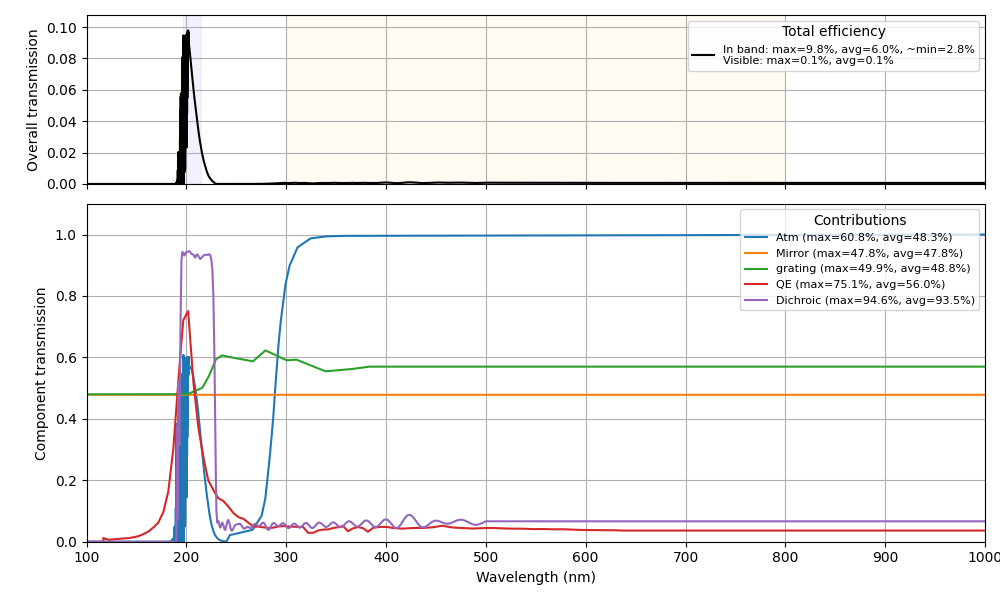

In [2]:
%matplotlib widget
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings("ignore")
# === Parameters ===
filename = "../Throughput.xlsx"
wavelength_range = np.linspace(100, 1000, 50000)  # nm
bandpass_range = (197, 215)
vis_range = (300, 800)

# === Read Excel file ===
xls = pd.ExcelFile(filename)
component_names = xls.sheet_names
dataframes = {name: pd.read_excel(xls, sheet_name=name).dropna() for name in component_names}

# === Per-component widgets ===
widgets_per_component = {}

for name in component_names:
    df = dataframes[name]
    # print(df)
    wv_name = df.columns[0]
    col_options = list(df.columns[1:])
    [col_options.remove(wi) for wi in col_options if 'wave' in wi.lower()]
    dropdown = widgets.Dropdown(options=col_options, value=col_options[0], layout=widgets.Layout(width='200px'))
    checkbox = widgets.Checkbox(value=True, description=name, indent=False, layout=widgets.Layout(width='80px'))
    slider = widgets.FloatSlider(value=1.0, min=0, max=1.0, step=0.01, layout=widgets.Layout(width='200px'))#,visible=False)
    slider.layout.visibility = 'hidden'
    slider_wavelength = widgets.FloatSlider(value=0, min=-20, max=20, step=0.1, layout=widgets.Layout(width='300px'),description='Δλ')#,visible=False)
    if name!="QE":
        slider_wavelength.layout.visibility = 'hidden'
    widgets_per_component[name] = {'checkbox': checkbox, 'dropdown': dropdown, 'slider': slider, 'slider_wavelength': slider_wavelength}

# === Extra widgets ===
ylog_checkbox = widgets.Checkbox(value=False, description='Log scale')
bandpass_checkbox = widgets.Checkbox(value=False, description='FB bandpass')

# === Plot output zone ===
out1 = widgets.Output()

# === Create plot ===
def create_plot():
    fig, (ax_top, ax_bottom) = plt.subplots(2, 1, sharex=True, figsize=(10, 6), height_ratios=[1, 2])

    ax_top.set_ylabel("Overall transmission")
    ax_top.grid(True)

    ax_bottom.set_xlabel("Wavelength (nm)")
    ax_bottom.set_ylabel("Component transmission")
    ax_bottom.grid(True)
    # Highlight bandpass_range (blue) and vis_range (orange)
    ax_top.fill_between(
        wavelength_range, 0, 1, 
        where=(wavelength_range >= bandpass_range[0]) & (wavelength_range <= bandpass_range[1]),
        color='blue', alpha=0.05, step='mid'
    )
    ax_top.fill_between(
        wavelength_range, 0, 1, 
        where=(wavelength_range >= vis_range[0]) & (wavelength_range <= vis_range[1]),
        color='orange', alpha=0.05, step='mid'
    )
    line_total, = ax_top.plot(wavelength_range, np.ones_like(wavelength_range), color='black')
    line_handles = {}
    for name in component_names:
        line, = ax_bottom.plot(wavelength_range, np.zeros_like(wavelength_range), label=name)
        line_handles[name] = line

    ax_bottom.legend(loc='upper right', fontsize=8)
    plt.tight_layout()
    return fig, ax_top, ax_bottom, line_total, line_handles


fig, ax_top, ax_bottom, line_total, line_handles = create_plot()

# === Update plot ===
def update_plot(change=None):
    with out1:
        # clear_output(wait=True)
        # fig, ax_top, ax_bottom, line_total, line_handles = create_plot()

        total_eff = np.ones_like(wavelength_range)
        bandpass_mask = (wavelength_range >= bandpass_range[0]) & (wavelength_range <= bandpass_range[1])
        vispass_mask = (wavelength_range >= vis_range[0]) & (wavelength_range <= vis_range[1])

        for name in component_names:
            widgets_set = widgets_per_component[name]
            visible = widgets_set['checkbox'].value
            col = widgets_set['dropdown'].value
            slider_val = widgets_set['slider'].value
            slider_wavelength_val = widgets_set['slider_wavelength'].value
            df = dataframes[name]
            loc_val = np.where(df.columns == col)[0][0]
            # print(np.where(df.columns == col),type(df.columns[loc_val - 1]))
            # Check if the previous column exists and contains 'wave' in its name
            if  "wave" in df.columns[loc_val - 1].lower():
                # print("Found wavelength column")
                raw_wl = df.iloc[:, loc_val - 1].values
                raw_eff = df.iloc[:, loc_val].values
            else:
                raw_wl = df.iloc[:, 0].values
                raw_eff = df[col].values
            
            if np.any(raw_eff > 1.01):
                # print(df.columns[loc_val])
                raw_eff = raw_eff / 100.

                # print(raw_wl)

            # normed = raw_eff - raw_eff.min()
            # if np.max(normed) > 0:
            #     normed /= np.max(normed)
            # scaled = slider_val * normed
            # scaled = raw_eff

            interp_func = interp1d(raw_wl+slider_wavelength_val, raw_eff, kind='linear', bounds_error=False, fill_value=0)#"extrapolate")
            eff_interp = interp_func(wavelength_range)

            if visible:
                line_handles[name].set_ydata(eff_interp)
                line_handles[name].set_visible(True)
                total_eff *= eff_interp

                max_val = np.max(eff_interp[bandpass_mask])
                avg_band = np.mean(eff_interp[bandpass_mask])
                # max_val_vis = np.max(eff_interp[vispass_mask])
                # avg_band_vis = np.mean(eff_interp[vispass_mask])
                line_handles[name].set_label(f"{name} (max={100*max_val:.1f}%, avg={100*avg_band:.1f}%)")
            else:
                line_handles[name].set_label("")
                line_handles[name].set_visible(False)

        line_total.set_ydata(total_eff)
        max_total = np.nanmax(total_eff[bandpass_mask])
        avg_total_band = np.nanmean(total_eff[bandpass_mask])
        min_total_band = np.nanpercentile(total_eff[bandpass_mask],10)

        avg_band_vis = np.mean(total_eff[vispass_mask])
        max_val_vis = np.max(total_eff[vispass_mask])
        line_total.set_label(f"In band: max={100*max_total:.1f}%, avg={100*avg_total_band:.1f}%, ~min={100*min_total_band:.1f}%\nVisible: max={100*max_val_vis:.1f}%, avg={100*avg_band_vis:.1f}%")

        ax_top.set_ylim(0.00001 if ylog_checkbox.value else 0, 1.1 * max_total)
        ax_bottom.set_ylim(0.00001 if ylog_checkbox.value else 0, 1.1)

        ax_top.set_yscale('log' if ylog_checkbox.value else 'linear')
        ax_bottom.set_yscale('log' if ylog_checkbox.value else 'linear')

        if bandpass_checkbox.value:
            ax_bottom.set_xlim(bandpass_range[0]-10, bandpass_range[-1]+10)
        else:
            ax_bottom.set_xlim(wavelength_range[0], wavelength_range[-1])

        ax_top.legend(loc='upper right', fontsize=8,title="Total efficiency")
        ax_bottom.legend(loc='upper right', fontsize=8,title="Contributions")
        fig.canvas.draw()
        # plt.show()

# === Connect widgets ===
for name, widget_set in widgets_per_component.items():
    for widget in widget_set.values():
        widget.observe(update_plot, names='value')

ylog_checkbox.observe(update_plot, names='value')
bandpass_checkbox.observe(update_plot, names='value')

# === Display ===
controls = widgets.VBox([
    widgets.HBox([ w['dropdown'], w['checkbox'], w['slider_wavelength'], w['slider']]) for w in widgets_per_component.values()
])
extra_controls = widgets.HBox([ylog_checkbox, bandpass_checkbox])

display(controls, extra_controls, out1)
update_plot()